In [1]:
%cd d

/home/neli1234/studium#/PmP/d


/usr/lib/python3/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='h5py')

import logging
logging.getLogger('h5py').setLevel(logging.ERROR)

import os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'



In [2]:
import glob
import xarray as xr


files = glob.glob('*.nc4')
ds = xr.open_mfdataset(files, combine='by_coords', engine='netcdf4')


print(ds)

<xarray.Dataset> Size: 447MB
Dimensions:  (lon: 576, time: 538, lat: 361)
Coordinates:
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 4kB 1980-01-01T00:30:00 ... 2024-10-01T00:...
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
Data variables:
    T2M      (time, lat, lon) float32 447MB dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
Attributes: (12/37)
    History:                             Original file generated: Fri May  8 ...
    Filename:                            MERRA2_100.tavgM_2d_slv_Nx.198001.nc4
    Comment:                             GMAO filename: d5124_m2_jan79.tavg1_...
    Conventions:                         CF-1
    Institution:                         NASA Global Modeling and Assimilatio...
    References:                          http://gmao.gsfc.nasa.gov
    ...                                  ...
    build_dmrpp_metadata.bes:            3.21.0-272
    buil

In [12]:
import xarray as xr
import pandas as pd
import numpy as np

def compute_region_stats(ds):
    """
    Berechnet für drei Regionen (Global, Europe, Arctic) den durchschnittlichen, 
    maximalen und minimalen Temperaturwert (in °C) sowie den Monat (Monat und Jahr), 
    in dem das Maximum bzw. Minimum auftrat.
    
    Regionen werden wie folgt definiert:
      - Global: lat -90 bis 90, lon -180 bis 180
      - Europe: lat 35 bis 70, lon -25 bis 45
      - Arctic: lat 66.5 bis 90, lon -180 bis 180
    
    Parameter:
      ds: xarray.Dataset mit der Variablen "T2M" (Temperatur in Kelvin)
      
    Rückgabe:
      Dictionary mit den berechneten Werten pro Region.
    """
    # Regionen
    regions = {
        "Global": {"lat": (-90, 90), "lon": (-180, 180)},
        "Europe": {"lat": (35, 70), "lon": (-25, 45)},
        "Arctic": {"lat": (66.5, 90), "lon": (-180, 180)},
    }
    
    results = {}
    
    for region, bounds in regions.items():
        lat_min, lat_max = bounds["lat"]
        lon_min, lon_max = bounds["lon"]
        # Regionale Teilmenge erstellen:
        ds_region = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
        
        # Mittelwert über lat und lon für jeden Zeitschritt berechnen:
        ts = ds_region["T2M"].mean(dim=["lat", "lon"]).compute()
        
        
        # In Celsius umrechnen:
        ts_c = ts - 273.15
        ts_series = ts_c.to_series()
        
        # Berechnung der Kennzahlen:
        avg_temp = ts_series.mean()
        max_temp = ts_series.max()
        min_temp = ts_series.min()
        
        # Ermittlung der Zeitpunkte (time stamps) für Maximum und Minimum:
        max_time = ts_series.idxmax()
        min_time = ts_series.idxmin()
        
        # Formatierung: Den Monat (und Jahr) als lesbaren String (z.B. "July 2010")
        max_month = max_time.strftime("%B %Y")
        min_month = min_time.strftime("%B %Y")
        
        results[region] = {
            "Avg Temp (°C)": avg_temp,
            "Max Temp (°C)": max_temp,
            "Max Month": max_month,
            "Min Temp (°C)": min_temp,
            "Min Month": min_month
        }
    
    return results


stats = compute_region_stats(ds)


In [13]:
for region, data in stats.items():
    print(f"Region: {region}")
    print(f"  Durchschnittstemperatur: {data['Avg Temp (°C)']:.2f} °C")
    print(f"  Höchste Temperatur: {data['Max Temp (°C)']:.2f} °C im {data['Max Month']}")
    print(f"  Niedrigste Temperatur: {data['Min Temp (°C)']:.2f} °C im {data['Min Month']}")
    print()

Region: Global
  Durchschnittstemperatur: 5.14 °C
  Höchste Temperatur: 8.13 °C im July 2024
  Niedrigste Temperatur: 2.30 °C im March 1982

Region: Europe
  Durchschnittstemperatur: 9.17 °C
  Höchste Temperatur: 18.86 °C im August 2022
  Niedrigste Temperatur: -1.59 °C im January 1987

Region: Arctic
  Durchschnittstemperatur: -11.59 °C
  Höchste Temperatur: 3.07 °C im July 2016
  Niedrigste Temperatur: -27.31 °C im February 1998



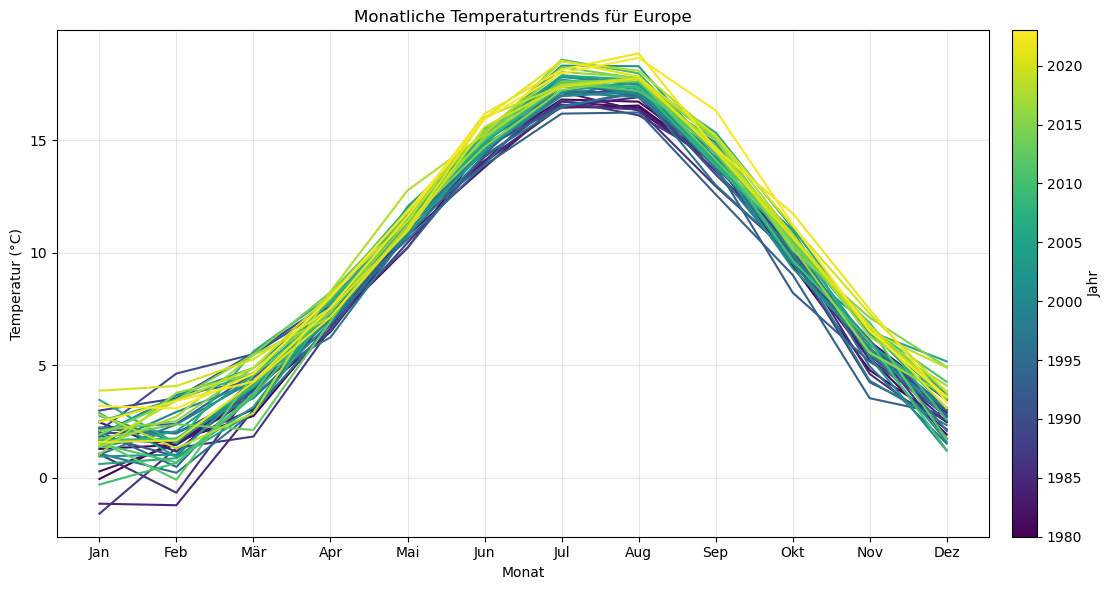

In [15]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd

def plot_temperature_trends(ds, region, start_year=None, end_year=None):
    """
    Plots the monthly temperature trends for multiple years for a given region using an xarray dataset.
    The colormap used is 'viridis', with a colorbar representing the years.
    
    Parameters:
      - ds: xarray.Dataset with variables 'time' and 'T2M'.
      - region: str, the region to analyze ('europe', 'global', 'america', 'arctic', etc.).
      - start_year: int, optional, the first year to include in the plot.
      - end_year: int, optional, the last year to include in the plot.
    """
    # Define region boundaries
    regions = {
        "europe": {'lat': (35, 70), 'lon': (-25, 45)},
        "global": {'lat': (-90, 90), 'lon': (-180, 180)},
        "north_america": {'lat': (15, 75), 'lon': (-170, -50)},
        "south_america": {'lat': (-55, 15), 'lon': (-85, -30)},
        "africa": {'lat': (-35, 37), 'lon': (-20, 55)},
        "asia": {'lat': (5, 80), 'lon': (60, 180)},
        "australia": {'lat': (-44, -10), 'lon': (112, 154)},
        "antarctica": {'lat': (-90, -60), 'lon': (-180, 180)},
        "arctic": {'lat': (66, 90), 'lon': (-180, 180)},
        "atlantic_ocean": {'lat': (-60, 60), 'lon': (-80, 20)},
        "pacific_ocean": {'lat': (-60, 60), 'lon': (-180, -80)},
        "indian_ocean": {'lat': (-50, 30), 'lon': (30, 120)},
        "southern_ocean": {'lat': (-90, -50), 'lon': (-180, 180)},
        "arctic_ocean": {'lat': (60, 90), 'lon': (-180, 180)}
    }
    
    if region.lower() not in regions:
        raise ValueError(f"Unknown region '{region}'. Available options: {list(regions.keys())}")
    
    # Set time coordinate to daily resolution
    ds = ds.assign_coords(time=ds.time.dt.floor("D"))
    
    # Subset the dataset based on the selected region
    lat_min, lat_max = regions[region]['lat']
    lon_min, lon_max = regions[region]['lon']
    ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
    
    # Filter by year range if specified
    if start_year:
        ds = ds.where(ds.time.dt.year >= start_year, drop=True)
    if end_year:
        ds = ds.where(ds.time.dt.year <= end_year, drop=True)
    
    # Compute the mean over lat and lon
    ds_mean = ds["T2M"].mean(dim=["lat", "lon"]).compute()
    
    # Convert to Pandas Series for grouping
    times = ds_mean.time.to_index()
    series = ds_mean.to_series()
    series.index = pd.MultiIndex.from_arrays([times.year, times.month], names=["year", "month"])
    
    # Compute monthly averages
    monthly_avg = series.groupby(level=["year", "month"]).mean()
    
    # Create pivot table with months as index and years as columns
    pivot_data = monthly_avg.unstack("year").sort_index(axis=1)
    
    # Define colormap
    cmap = cm.viridis
    years = pivot_data.columns
    norm = mcolors.Normalize(vmin=years.min(), vmax=years.max())
    colors = cmap(np.linspace(0, 1, len(years)))
    
    plt.figure(figsize=(12, 6))
    
    # Plot each year's data
    for (year, temps), color in zip(pivot_data.items(), colors):
        plt.plot(pivot_data.index, temps - 273.15, color=color)
    
    plt.xlabel("Monat")
    plt.ylabel("Temperatur (°C)")
    plt.title(f"Monatliche Temperaturtrends für {region.capitalize()}")
    plt.xticks(
        ticks=np.arange(1, 13),
        labels=["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"]
    )
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, pad=0.02)
    cbar.set_label("Jahr")
    
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_temperature_trends(ds, region="europe", start_year=1980, end_year=2023)


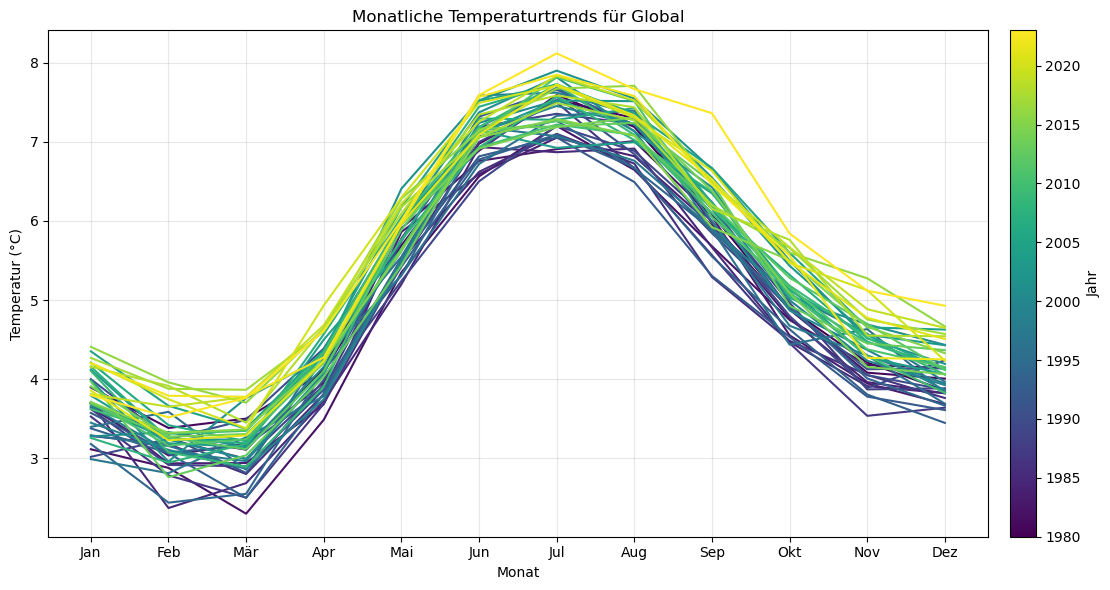

In [16]:
plot_temperature_trends(ds, region="global", start_year=1980, end_year=2023)

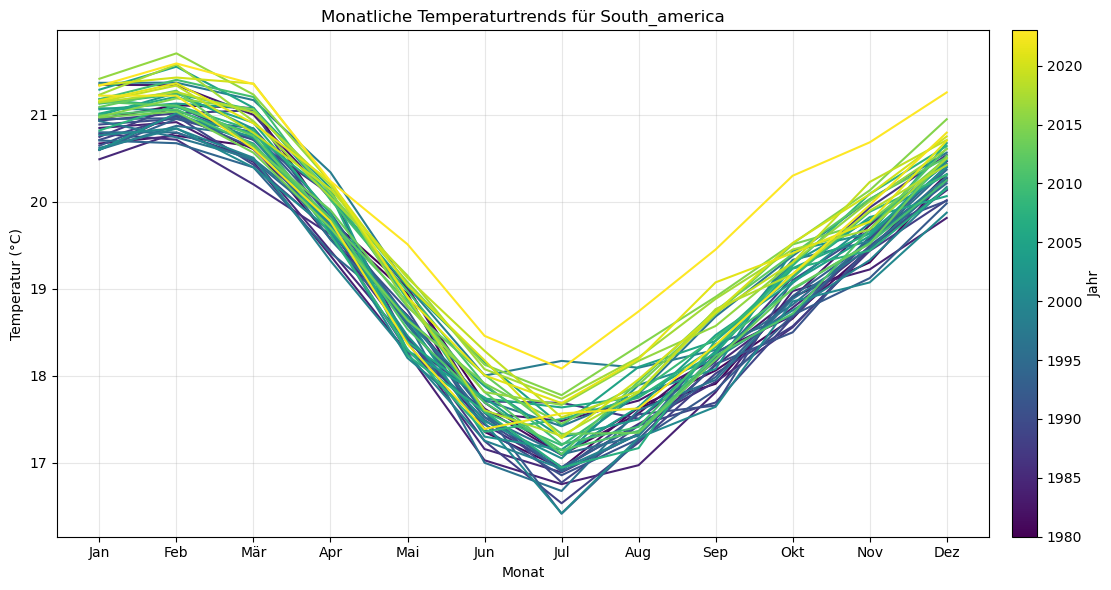

In [17]:
plot_temperature_trends(ds, region="south_america", start_year=1980, end_year=2023)

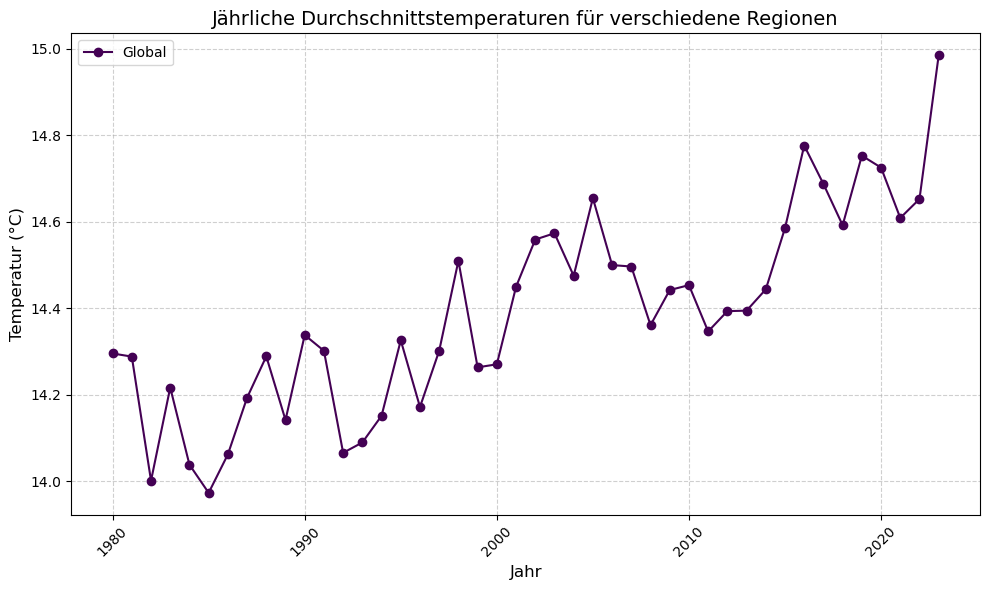

In [30]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_annual_avg_temperature(ds, regions, start_year=None, end_year=None):
    """
    Plots the annual average temperature for multiple regions on the same plot.
    
    Parameters:
      - ds: xarray.Dataset with variables 'time' and 'T2M'.
      - regions: list of str, the regions to analyze (e.g., ['europe', 'global']).
      - start_year: int, optional, the first year to include in the plot.
      - end_year: int, optional, the last year to include in the plot.
    """
    # Define region boundaries
    region_boundaries = {
        "europe": {'lat': (35, 70), 'lon': (-25, 45)},
        "global": {'lat': (-90, 90), 'lon': (-180, 180)},
        "north_america": {'lat': (15, 75), 'lon': (-170, -50)},
        "south_america": {'lat': (-55, 15), 'lon': (-85, -30)},
        "africa": {'lat': (-35, 37), 'lon': (-20, 55)},
        "asia": {'lat': (5, 80), 'lon': (60, 180)},
        "australia": {'lat': (-44, -10), 'lon': (112, 154)},
        "antarctica": {'lat': (-90, -60), 'lon': (-180, 180)},
        "arctic": {'lat': (66, 90), 'lon': (-180, 180)},
        "atlantic_ocean": {'lat': (-60, 60), 'lon': (-80, 20)},
        "pacific_ocean": {'lat': (-60, 60), 'lon': (-180, -80)},
        "indian_ocean": {'lat': (-50, 30), 'lon': (30, 120)},
        "southern_ocean": {'lat': (-90, -50), 'lon': (-180, 180)},
        "arctic_ocean": {'lat': (60, 90), 'lon': (-180, 180)}
    }
    
    # Convert time coordinate to pandas-DatetimeIndex
    ds = ds.assign_coords(time=pd.to_datetime(ds['time'].values))
    
    # Extract years and add as a new coordinate
    ds = ds.assign_coords(year=("time", ds.time.dt.year.data))
    
    plt.figure(figsize=(10, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(regions)))
    
    for region, color in zip(regions, colors):
        if region.lower() not in region_boundaries:
            raise ValueError(f"Unknown region '{region}'. Available options: {list(region_boundaries.keys())}")
        
        # Subset dataset based on the selected region
        lat_min, lat_max = region_boundaries[region]['lat']
        lon_min, lon_max = region_boundaries[region]['lon']
        region_ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
        
        # Filter by year range if specified
        if start_year:
            region_ds = region_ds.where(region_ds.year >= start_year, drop=True)
        if end_year:
            region_ds = region_ds.where(region_ds.year <= end_year, drop=True)
        
        # Compute latitude weights
        latitudes = region_ds['lat'].values
        weights = np.cos(np.deg2rad(latitudes))
        weights_da = xr.DataArray(weights, coords=[region_ds['lat']], dims=["lat"])
        
        # Compute annual average temperature with weighting
        annual_avg_temperature = (
            region_ds['T2M']
            .groupby('year')
            .mean(dim='time')
            .weighted(weights_da)
            .mean(dim=['lat', 'lon'])
        )
        
        # Convert from Kelvin to Celsius
        annual_avg_temperature_celsius = annual_avg_temperature - 273.15
        
        # Plot the results
        plt.plot(
            annual_avg_temperature['year'],
            annual_avg_temperature_celsius,
            marker='o',
            linestyle='-',
            color=color,
            label=f'{region.capitalize()}'
        )
    
    plt.title("Jährliche Durchschnittstemperaturen für verschiedene Regionen", fontsize=14)
    plt.xlabel("Jahr", fontsize=12)
    plt.ylabel("Temperatur (°C)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.xticks(rotation=45, fontsize=10)
    
    plt.tight_layout()
    plt.show()

plot_annual_avg_temperature(ds, regions=["global"], start_year=1980, end_year=2023)

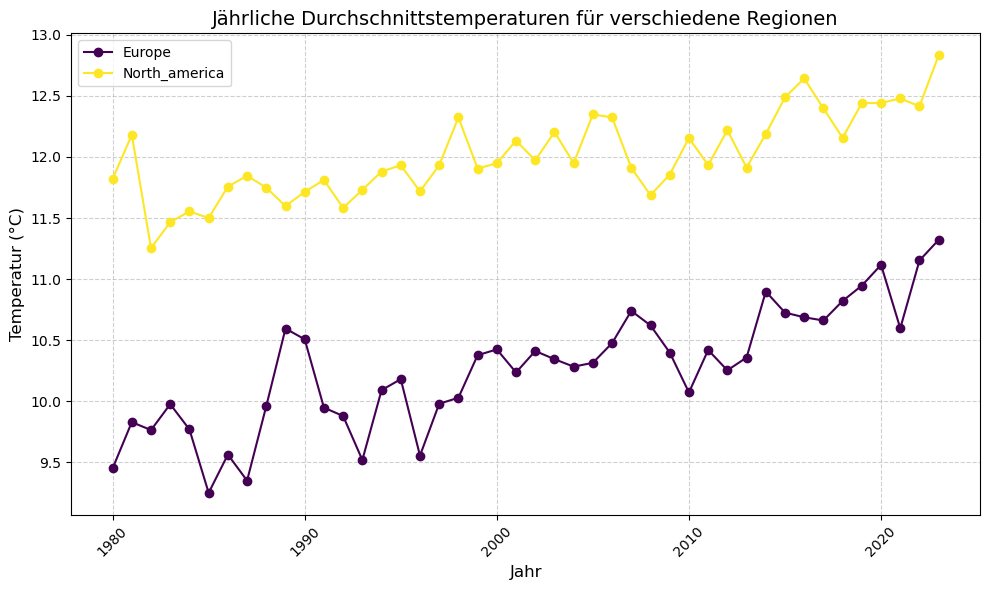

In [31]:
plot_annual_avg_temperature(ds, regions=["europe" ,"north_america"], start_year=1980, end_year=2023)

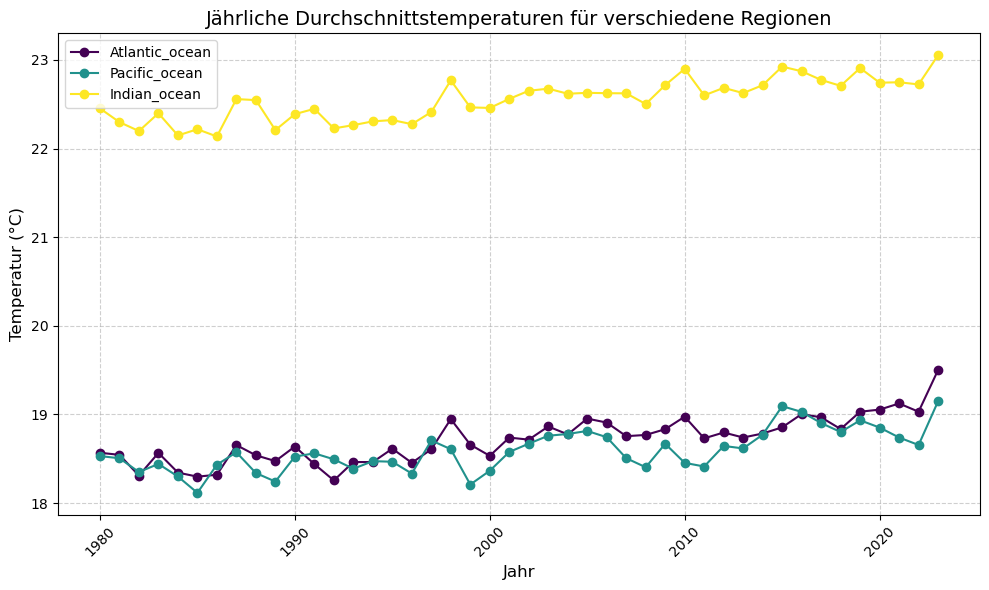

In [32]:
plot_annual_avg_temperature(ds, regions=["atlantic_ocean", "pacific_ocean","indian_ocean"], start_year=1980, end_year=2023)

In [39]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def boxplot_daily_temps(ds, region="europe", start_year=None, end_year=None):
    """
    Visualizes the distribution of daily temperatures using a boxplot and
    returns extreme outliers (values outside whiskers).
    """
    regions = {
        "europe": {'lat': (35, 70), 'lon': (-25, 45)},
        "america": {'lat': (-55, 70), 'lon': (-170, -30)},
        "arctic": {'lat': (66, 90), 'lon': (-180, 180)},
        "global": {'lat': (-90, 90), 'lon': (-180, 180)}
    }
    
    if region not in regions:
        raise ValueError(f"Unknown region: {region}")
    
    lat_min, lat_max = regions[region]['lat']
    lon_min, lon_max = regions[region]['lon']
    ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
    
    ds = ds.assign_coords(time=ds.time.dt.floor("D"))
    if start_year:
        ds = ds.where(ds.time.dt.year >= start_year, drop=True)
    if end_year:
        ds = ds.where(ds.time.dt.year <= end_year, drop=True)
    
    daily_temp = ds["T2M"].mean(dim=["lat", "lon"]).compute() - 273.15
    df = daily_temp.to_dataframe(name="temp").reset_index()
    df["year"] = df["time"].dt.year
    df["month"] = df["time"].dt.month_name().str.slice(stop=3)
    
    plt.figure(figsize=(12, 6))
    month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                   "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    ax = sns.boxplot(x="month", y="temp", data=df, order=month_order)
    
    plt.xlabel("Month")
    plt.ylabel("Daily Temperature (°C)")
    plt.title(f"Distribution of Daily Temperatures in {region.capitalize()}")
    plt.tight_layout()
    plt.show()
    
    outliers = df.groupby("month")["temp"].apply(lambda x: x[(x < x.quantile(0.25) - 1.5 * (x.quantile(0.75) - x.quantile(0.25))) | 
                                                                (x > x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25)))])
    print("Extreme Outliers:")
    print(outliers)
    return 

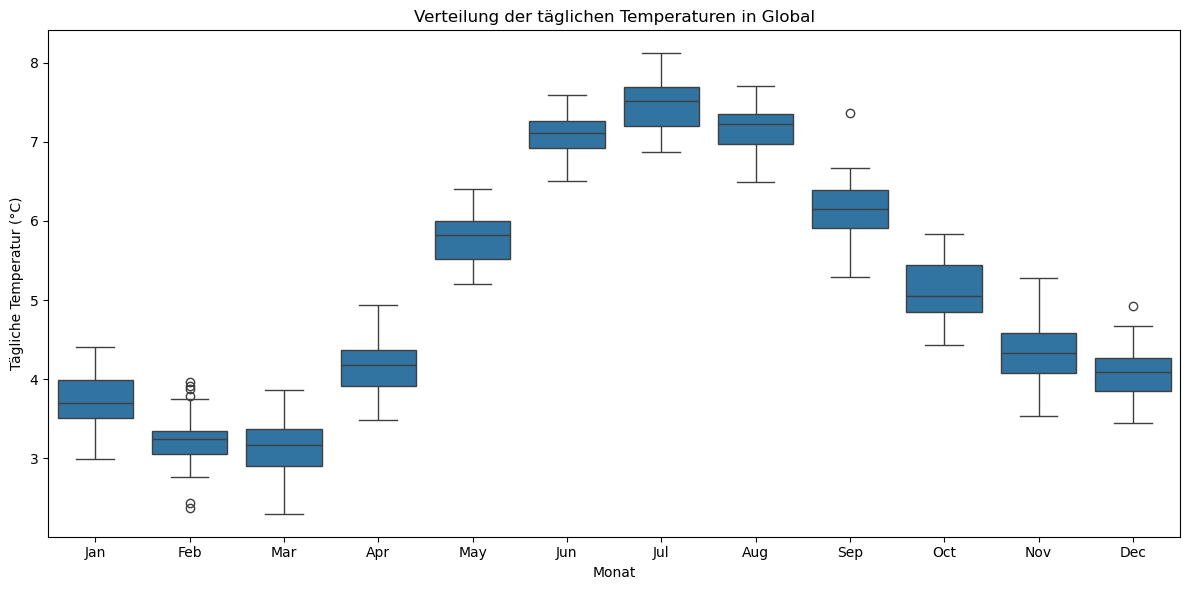

Extreme Ausreißer:
Feb:
  Jahr: 1985.0, Temperatur: 2.37°C
  Jahr: 1994.0, Temperatur: 2.44°C
  Jahr: 2016.0, Temperatur: 3.96°C
  Jahr: 2017.0, Temperatur: 3.88°C
  Jahr: 2018.0, Temperatur: 3.91°C
  Jahr: 2022.0, Temperatur: 3.79°C
Sep:
  Jahr: 2023.0, Temperatur: 7.36°C
Dec:
  Jahr: 2023.0, Temperatur: 4.93°C


{'Feb': [[1985.0, 2.372039794921875],
  [1994.0, 2.439849853515625],
  [2016.0, 3.959930419921875],
  [2017.0, 3.8787841796875],
  [2018.0, 3.91497802734375],
  [2022.0, 3.79095458984375]],
 'Sep': [[2023.0, 7.360626220703125]],
 'Dec': [[2023.0, 4.92742919921875]]}

In [25]:
boxplot_daily_temps(ds, region="global", start_year=1980, end_year=2023)

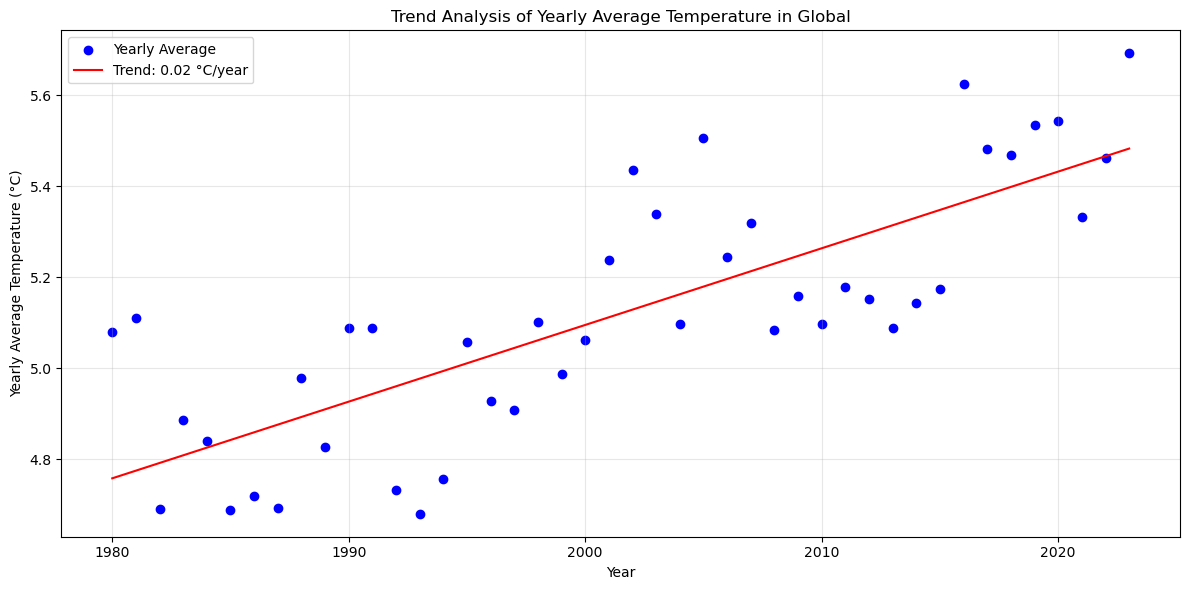

In [20]:
def trend_analysis_yearly_avg_temp(ds, region="global", start_year=None, end_year=None):
    """
    Performs a trend analysis on the yearly average temperatures for a given region.
    
    Parameters:
      - ds: xarray.Dataset with variables 'time' and 'T2M' (temperature in Kelvin)
      - region: str, the region to analyze
      - start_year: int, optional, first year to include
      - end_year: int, optional, last year to include
    """
    # Define regions (same as above)
    regions = {
        "global": {"lat": slice(-90, 90), "lon": slice(-180, 180)},
        "europe": {"lat": slice(35, 70), "lon": slice(-25, 45)},
        "north_america": {"lat": slice(15, 80), "lon": slice(-170, -50)},
        "south_america": {"lat": slice(-55, 15), "lon": slice(-85, -30)},
        "africa": {"lat": slice(-35, 40), "lon": slice(-20, 55)},
        "asia": {"lat": slice(5, 80), "lon": slice(60, 180)},
        "australia": {"lat": slice(-44, -10), "lon": slice(112, 154)},
        "arctic": {"lat": slice(66, 90), "lon": slice(-180, 180)},
        "antarctic": {"lat": slice(-90, -66), "lon": slice(-180, 180)}
    }
    
    if region not in regions:
        raise ValueError(f"Region '{region}' not recognized. Available regions: {list(regions.keys())}")
    
    # Subset dataset
    ds_region = ds.sel(lat=regions[region]['lat'], lon=regions[region]['lon'])
    ds_region = ds_region.assign_coords(time=ds_region.time.dt.floor("D"))
    
    # Filter by years if specified
    if start_year:
        ds_region = ds_region.where(ds_region.time.dt.year >= start_year, drop=True)
    if end_year:
        ds_region = ds_region.where(ds_region.time.dt.year <= end_year, drop=True)
    
    # Compute yearly average temperature
    df = ds_region["T2M"].mean(dim=["lat", "lon"]).compute().to_dataframe(name="temp")
    df["year"] = df.index.get_level_values("time").year
    yearly_avg = df.groupby("year")["temp"].mean() - 273.15
    
    # Trend analysis
    coeffs = np.polyfit(yearly_avg.index, yearly_avg.values, 1)
    trend_line = np.poly1d(coeffs)
    
    plt.figure(figsize=(12, 6))
    plt.scatter(yearly_avg.index, yearly_avg.values, color="blue", label="Yearly Average")
    plt.plot(yearly_avg.index, trend_line(yearly_avg.index), color="red", label=f"Trend: {coeffs[0]:.2f} °C/year")
    plt.xlabel("Year")
    plt.ylabel("Yearly Average Temperature (°C)")
    plt.title(f"Trend Analysis of Yearly Average Temperature in {region.capitalize()}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    
trend_analysis_yearly_avg_temp(ds, region="global", start_year=1980, end_year=2023)  

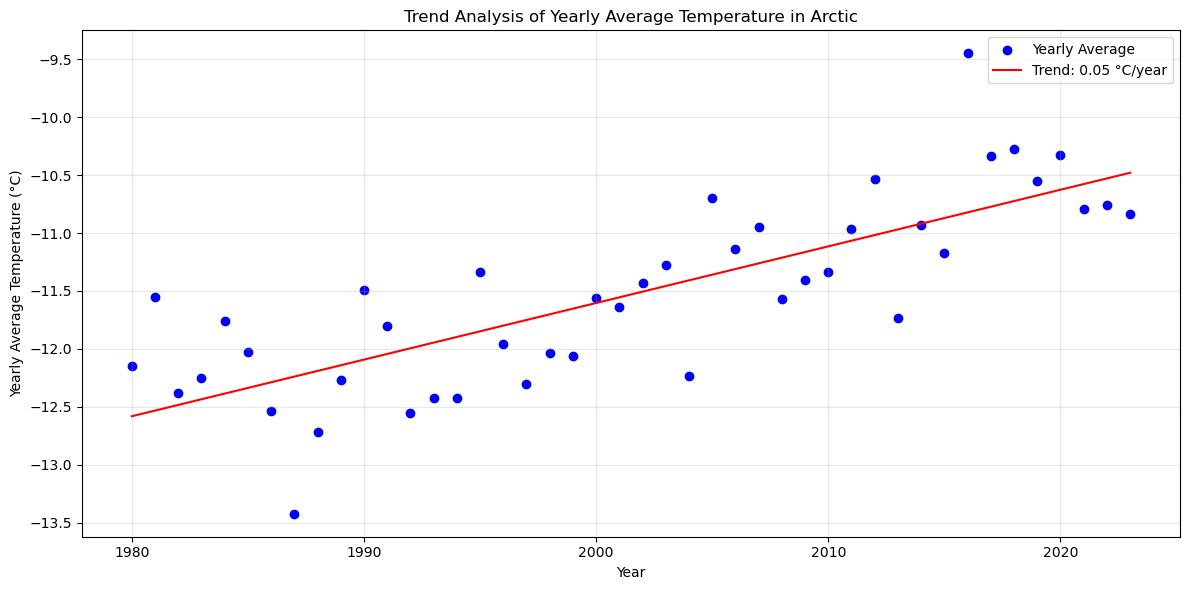

In [21]:
trend_analysis_yearly_avg_temp(ds, region="arctic", start_year=1980, end_year=2023) 

In [24]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def boxplot_daily_temps(ds, region="europe", start_year=None, end_year=None):
    """
    Visualisiert die Verteilung der täglichen Temperaturen mit einem Boxplot und
    gibt extreme Ausreißer (Werte außerhalb der Whisker) zusammen mit den entsprechenden Jahren zurück.
    """
    regions = {
        "europe": {'lat': (35, 70), 'lon': (-25, 45)},
        "america": {'lat': (-55, 70), 'lon': (-170, -30)},
        "arctic": {'lat': (70, 90), 'lon': (-180, 180)},
        "global": {'lat': (-90, 90), 'lon': (-180, 180)}
    }
    
    if region not in regions:
        raise ValueError(f"Unbekannte Region: {region}")
    
    lat_min, lat_max = regions[region]['lat']
    lon_min, lon_max = regions[region]['lon']
    ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
    
    ds = ds.assign_coords(time=ds.time.dt.floor("D"))
    if start_year:
        ds = ds.where(ds.time.dt.year >= start_year, drop=True)
    if end_year:
        ds = ds.where(ds.time.dt.year <= end_year, drop=True)
    
    daily_temp = ds["T2M"].mean(dim=["lat", "lon"]).compute() - 273.15
    df = daily_temp.to_dataframe(name="temp").reset_index()
    df["year"] = df["time"].dt.year
    df["month"] = df["time"].dt.month_name().str.slice(stop=3)
    
    plt.figure(figsize=(12, 6))
    month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                   "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    ax = sns.boxplot(x="month", y="temp", data=df, order=month_order)
    
    plt.xlabel("Monat")
    plt.ylabel("Tägliche Temperatur (°C)")
    plt.title(f"Verteilung der täglichen Temperaturen in {region.capitalize()}")
    plt.tight_layout()
    plt.show()
    
    # Berechnung des Interquartilsabstands (IQR) für jeden Monat
    iqr = df.groupby("month")["temp"].apply(lambda x: x.quantile(0.75) - x.quantile(0.25))
    q1 = df.groupby("month")["temp"].quantile(0.25)
    q3 = df.groupby("month")["temp"].quantile(0.75)
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Identifikation der Ausreißer
    outliers = {}
    for month in month_order:
        month_data = df[df["month"] == month]
        month_outliers = month_data[(month_data["temp"] < lower_bound[month]) | 
                                    (month_data["temp"] > upper_bound[month])]
        if not month_outliers.empty:
            outliers[month] = month_outliers[["year", "temp"]].values.tolist()
    
    if outliers:
        print("Extreme Ausreißer:")
        for month, values in outliers.items():
            print(f"{month}:")
            for year, temp in values:
                print(f"  Jahr: {year}, Temperatur: {temp:.2f}°C")
    else:
        print("Keine extremen Ausreißer gefunden.")
    
    return outliers


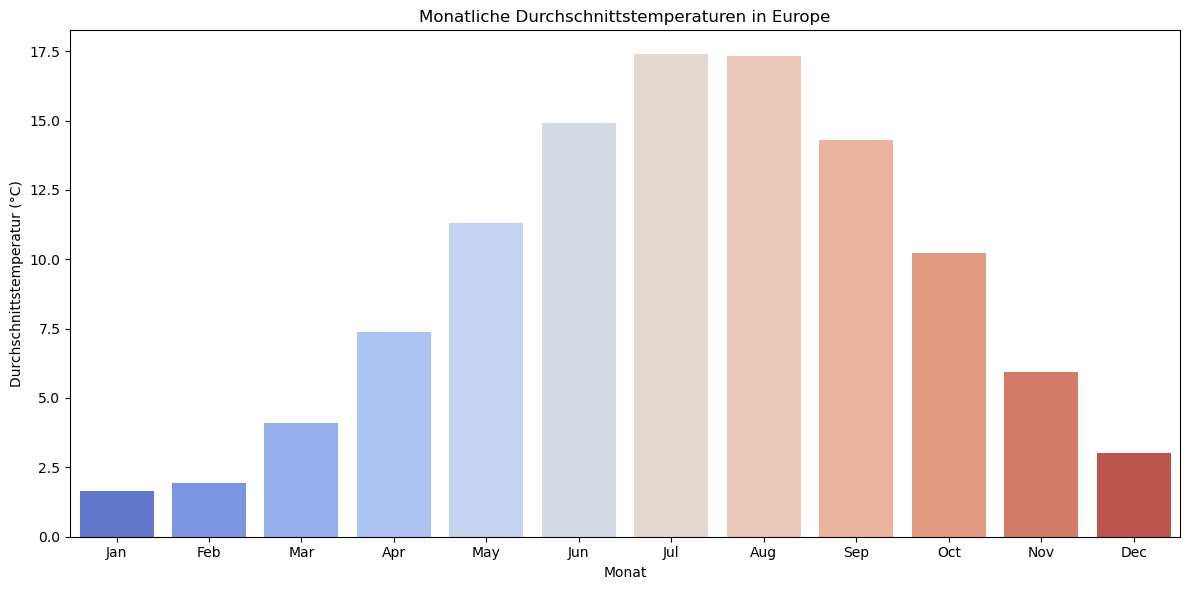

In [27]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def barplot_monthly_avg_temp(ds, region="europe", start_year=None, end_year=None):
    """
    Erstellt ein Balkendiagramm der monatlichen Durchschnittstemperaturen.
    """
    regions = {
        "europe": {'lat': (35, 70), 'lon': (-25, 45)},
        "america": {'lat': (-55, 70), 'lon': (-170, -30)},
        "arctic": {'lat': (70, 90), 'lon': (-180, 180)},
        "global": {'lat': (-90, 90), 'lon': (-180, 180)}
    }
    
    if region not in regions:
        raise ValueError(f"Unbekannte Region: {region}")
    
    lat_min, lat_max = regions[region]['lat']
    lon_min, lon_max = regions[region]['lon']
    ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
    
    ds = ds.assign_coords(time=ds.time.dt.floor("D"))
    if start_year:
        ds = ds.where(ds.time.dt.year >= start_year, drop=True)
    if end_year:
        ds = ds.where(ds.time.dt.year <= end_year, drop=True)
    
    daily_temp = ds["T2M"].mean(dim=["lat", "lon"]).compute() - 273.15
    df = daily_temp.to_dataframe(name="temp").reset_index()
    df["month"] = df["time"].dt.month_name().str.slice(stop=3)
    
    # Definieren der Monatsreihenfolge
    month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                   "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    
    monthly_avg = df.groupby("month")["temp"].mean().reindex(month_order)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette="coolwarm")
    plt.xlabel("Monat")
    plt.ylabel("Durchschnittstemperatur (°C)")
    plt.title(f"Monatliche Durchschnittstemperaturen in {region.capitalize()}")
    plt.tight_layout()
    plt.show()

barplot_monthly_avg_temp(ds, region="europe", start_year=1980, end_year=2023)

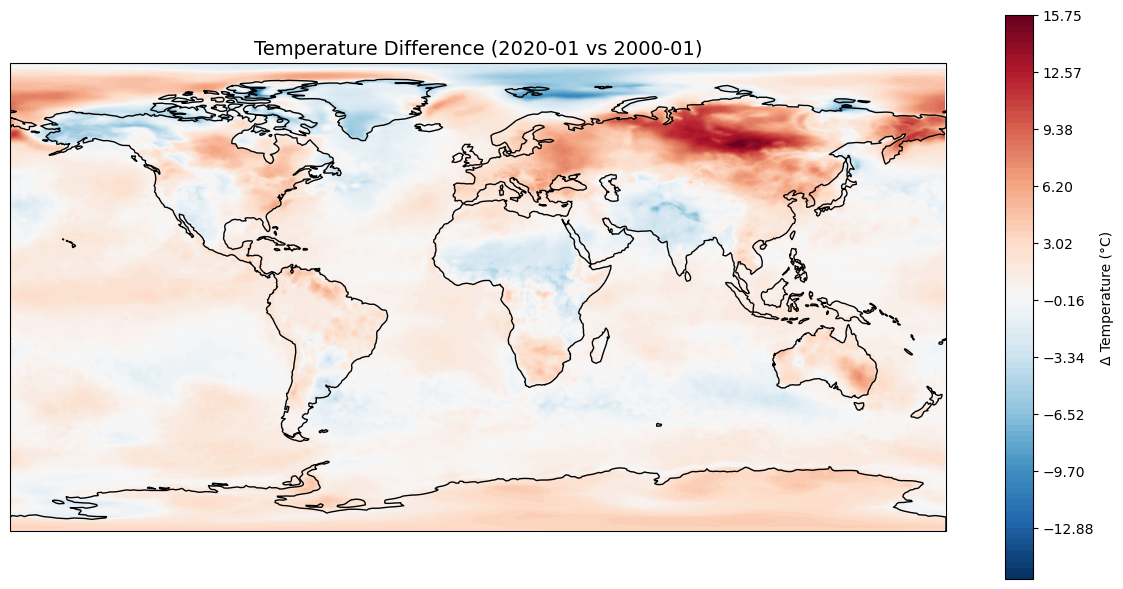

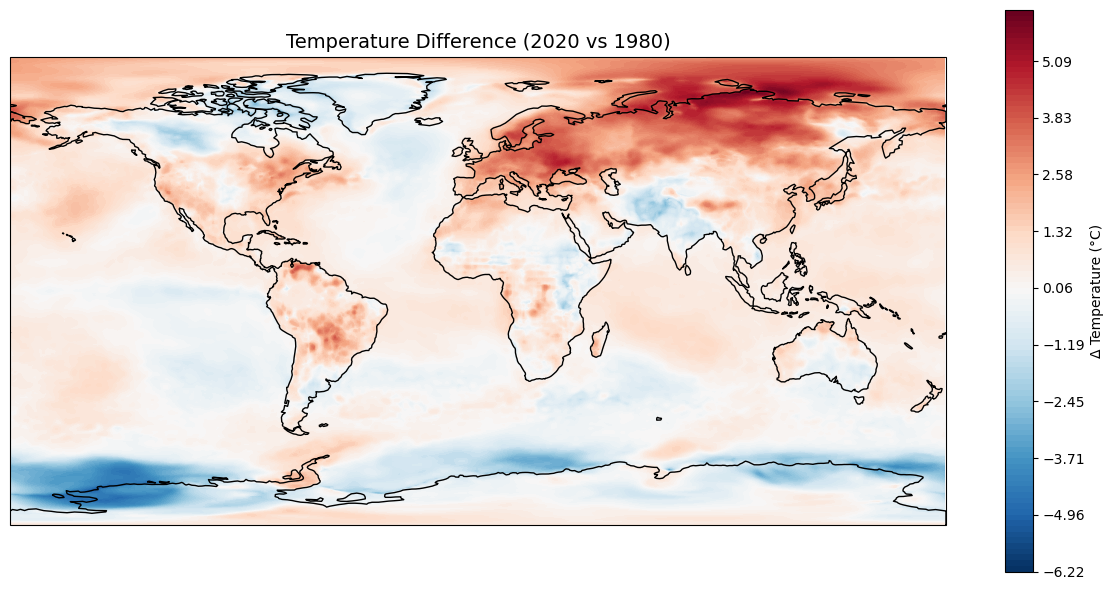

In [28]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import os

def plot_temperature_difference(ds, time1, time2, output_path=None):
    """
    Plots the difference in temperature (°C) between two time periods on a world map.
    
    Parameters:
      - ds: xarray.Dataset with variables 'time', 'lat', 'lon' and 'T2M' (in Kelvin)
      - time1: str, either "YYYY-MM" (for a specific month) or "YYYY" (for annual average)
      - time2: str, either "YYYY-MM" or "YYYY"
      - output_path: str, optional file path to save the plot image.
      
    The function selects the data corresponding to the specified periods:
      - If a period is given as "YYYY-MM", only that month is selected.
      - If given as "YYYY", the annual mean over all available months in that year is computed.
      
    The temperature difference is computed as: (Period2 - Period1) in °C.
    """
    
    def select_period(ds, period_str):
        # If the string has a '-', we assume "YYYY-MM" and select that month exactly.
        if '-' in period_str:
            # Convert string to Timestamp
            period_ts = pd.to_datetime(period_str)
            # Select data for that month. If there are multiple time steps in that month, average them.
            ds_period = ds.sel(time=period_ts, method='nearest')
            # In case the dataset has more than one data point in the month,
            # you could also consider ds.sel(time=ds.time.dt.strftime("%Y-%m") == period_str)
        else:
            # Assume period_str is a year.
            year = int(period_str)
            ds_period = ds.where(ds.time.dt.year == year, drop=True)
            # Average over the year if more than one time step exists.
            ds_period = ds_period.mean(dim='time')
        return ds_period

    # Select the two periods. They can be monthly or annual.
    ds_period1 = select_period(ds, time1)
    ds_period2 = select_period(ds, time2)

    # Compute the spatial mean difference if desired per grid point.
    # Here we assume you want the difference at every grid point.
    # Convert from Kelvin to Celsius difference:
    temp1_c = ds_period1['T2M'] - 273.15
    temp2_c = ds_period2['T2M'] - 273.15
    temp_diff = temp2_c - temp1_c

    # Prepare meshgrid for plotting.
    latitudes = ds['lat'].values
    longitudes = ds['lon'].values
    lon, lat = np.meshgrid(longitudes, latitudes)

    # Plot the difference on a world map.
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.coastlines()

    # Define levels for a diverging colormap.
    # Use a symmetric interval around zero so that cooling and warming are equally represented.
    diff_abs_max = np.nanmax(np.abs(temp_diff.values))
    levels = np.linspace(-diff_abs_max, diff_abs_max, 100)

    # Use a diverging colormap (e.g. RdBu_r: red for warming, blue for cooling).
    c = ax.contourf(lon, lat, temp_diff.values, cmap='RdBu_r', levels=levels, transform=ccrs.PlateCarree())
    cb = fig.colorbar(c, ax=ax, orientation='vertical', label='Δ Temperature (°C)')

    # Create an informative title.
    ax.set_title(f'Temperature Difference ({time2} vs {time1})', fontsize=14)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.tight_layout()
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=150)
        print(f"Plot saved to {output_path}")
    plt.show()



# To compare two months, e.g. January 2000 and January 2020:
plot_temperature_difference(ds, time1="2000-01", time2="2020-01")

# To compare two annual means, e.g. 2000 vs 2020:
plot_temperature_difference(ds, time1="1980", time2="2020")

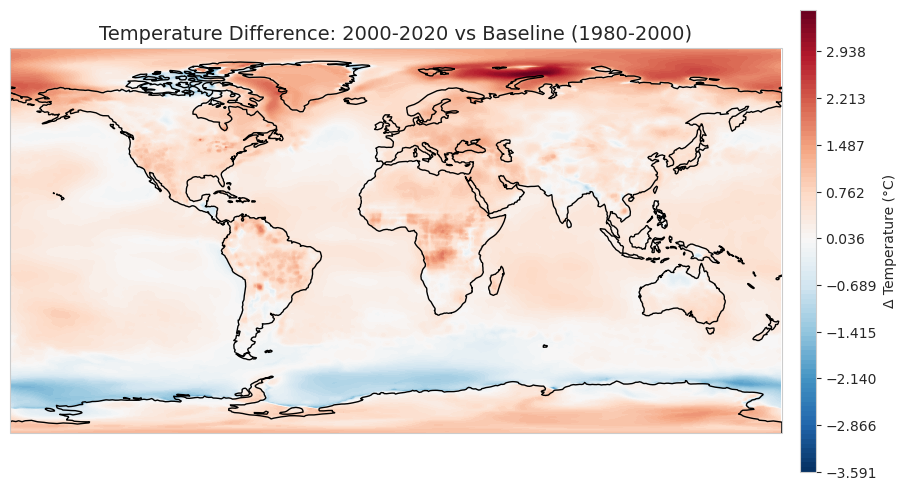

In [51]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import os

def plot_temperature_difference(ds, time1, time2, output_path=None):
    """
    Plots the temperature difference (°C) between a target year and a baseline period.
    
    Parameters:
      - ds: xarray.Dataset with variables 'time', 'lat', 'lon', and 'T2M' (in Kelvin)
      - time1: str, baseline period (e.g., "1981-2010") or a single year/month
      - time2: str, target period (e.g., "2020" or "2020-07")
      - output_path: str, optional path to save the plot
    """
    
    def select_period(ds, period_str):
        if '-' in period_str:
            parts = period_str.split('-')
            # Handle multi-year baseline (e.g., "1981-2010")
            if len(parts) == 2 and len(parts[0]) == 4 and len(parts[1]) == 4:
                start_year, end_year = map(int, parts)
                # Extract all data in the baseline period
                ds_period = ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))
                # Compute annual means first, then average over the baseline period
                annual_means = ds_period.groupby('time.year').mean(dim='time')
                return annual_means.mean(dim='year')
            # Handle single month (e.g., "2020-07")
            else:
                time_str = ds.time.dt.strftime("%Y-%m")
                ds_period = ds.where(time_str == period_str, drop=True)
                return ds_period.mean(dim='time')
        # Handle single year (e.g., "2020")
        else:
            year = int(period_str)
            ds_period = ds.sel(time=ds.time.dt.year == year)
            return ds_period.mean(dim='time')

    # Select baseline and target periods
    ds_baseline = select_period(ds, time1)
    ds_target = select_period(ds, time2)

    # Compute temperature difference in Celsius
    temp_diff = (ds_target['T2M'] - 273.15) - (ds_baseline['T2M'] - 273.15)

    # Plotting setup
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.coastlines()

    # Colormap levels (symmetric around zero)
    max_diff = np.nanmax(np.abs(temp_diff.values))
    levels = np.linspace(-max_diff, max_diff, 100)
    
    # Plot temperature difference
    contour = ax.contourf(ds.lon, ds.lat, temp_diff, 
                         levels=levels, cmap='RdBu_r', 
                         transform=ccrs.PlateCarree())
    
    # Add colorbar and title
    cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.02, 
                        aspect=30, label='Δ Temperature (°C)')
    ax.set_title(f'Temperature Difference: {time2} vs Baseline ({time1})', fontsize=14)

    # Save or show
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=150)
    plt.show()

# Example usage:
# Compare 2020 to 1981-2010 baseline
plot_temperature_difference(ds, time1="1980-2000", time2="2000-2020")

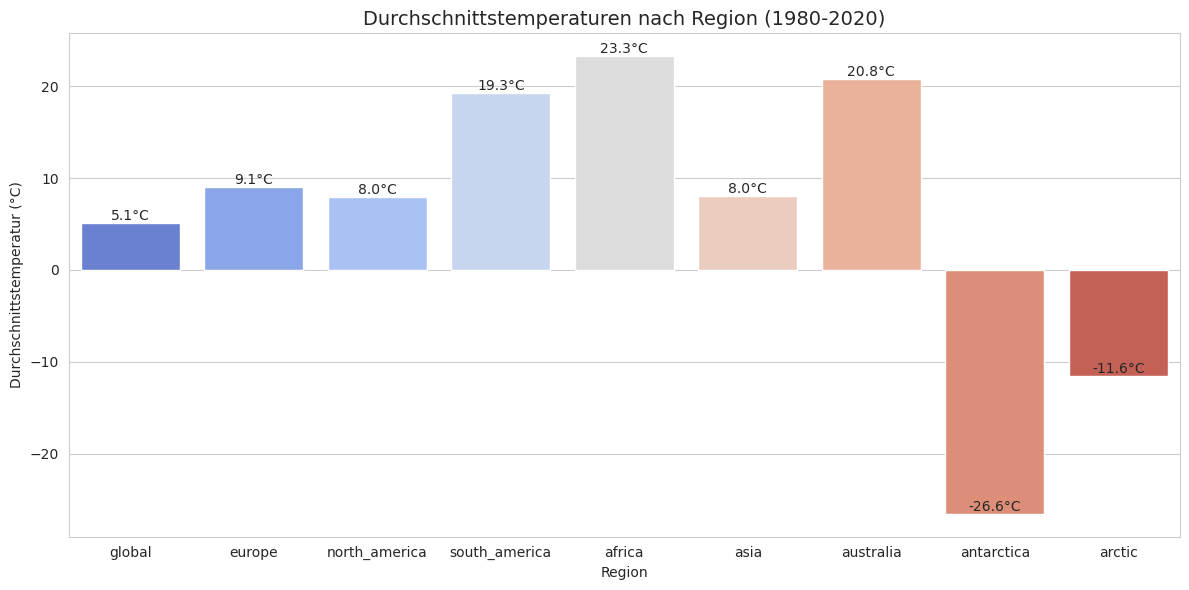

In [48]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def barplot_regional_avg_temp(ds, regions=["europe"], start_year=None, end_year=None):
    """
    Erstellt ein Balkendiagramm der Durchschnittstemperaturen für mehrere Regionen über den gesamten Zeitraum.
    
    Parameter:
      - regions: Liste von Regionen (z.B. ["europe", "arctic"])
      - start_year: Startjahr für den Zeitraum (optional)
      - end_year: Endjahr für den Zeitraum (optional)
    """
    region_defs = {
        "europe": {'lat': (35, 70), 'lon': (-25, 45)},
        "global": {'lat': (-90, 90), 'lon': (-180, 180)},
        "north_america": {'lat': (15, 75), 'lon': (-170, -50)},
        "south_america": {'lat': (-55, 15), 'lon': (-85, -30)},
        "africa": {'lat': (-35, 37), 'lon': (-20, 55)},
        "asia": {'lat': (5, 80), 'lon': (60, 180)},
        "australia": {'lat': (-44, -10), 'lon': (112, 154)},
        "antarctica": {'lat': (-90, -60), 'lon': (-180, 180)},
        "arctic": {'lat': (66, 90), 'lon': (-180, 180)},
        "atlantic_ocean": {'lat': (-60, 60), 'lon': (-80, 20)},
        "pacific_ocean": {'lat': (-60, 60), 'lon': (-180, -80)},
        "indian_ocean": {'lat': (-50, 30), 'lon': (30, 120)},
        "southern_ocean": {'lat': (-90, -50), 'lon': (-180, 180)},
        "arctic_ocean": {'lat': (60, 90), 'lon': (-180, 180)}
    }
    # Prüfe gültige Regionen
    for region in regions:
        if region not in region_defs:
            raise ValueError(f"Unbekannte Region: {region}")

    averages = {}
    
    for region in regions:
        # Region ausschneiden
        lat_range = region_defs[region]['lat']
        lon_range = region_defs[region]['lon']
        ds_region = ds.sel(
            lat=slice(*lat_range),
            lon=slice(*lon_range)
        )

        # Zeitfilter anwenden
        if start_year or end_year:
            time_slice = slice(
                f"{start_year}-01-01" if start_year else None,
                f"{end_year}-12-31" if end_year else None
            )
            ds_region = ds_region.sel(time=time_slice)

        # Temperatur berechnen (Mittelwert über Raum und Zeit)
        temp_kelvin = ds_region['T2M'].mean(dim=['lat', 'lon', 'time']).compute()
        temp_celsius = float(temp_kelvin - 273.15)
        averages[region] = temp_celsius

    # Plot erstellen
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    bars = sns.barplot(
        x=list(averages.keys()),
        y=list(averages.values()),
        palette="coolwarm"
    )

    # Titel und Labels
    time_range = ""
    if start_year and end_year:
        time_range = f" ({start_year}-{end_year})"
    elif start_year:
        time_range = f" (ab {start_year})"
    elif end_year:
        time_range = f" (bis {end_year})"

    plt.title(f"Durchschnittstemperaturen nach Region{time_range}", fontsize=14)
    plt.xlabel("Region")
    plt.ylabel("Durchschnittstemperatur (°C)")
    
    # Werte an den Balken anzeigen
    for bar in bars.patches:
        bars.annotate(f"{bar.get_height():.1f}°C",
                      (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                      ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    
barplot_regional_avg_temp(
    ds,
    regions = [
    "global",
    "europe",
    "north_america",
    "south_america",
    "africa",
    "asia",
    "australia",
    "antarctica",
    "arctic"
],
    start_year=1980,
    end_year=2020
)


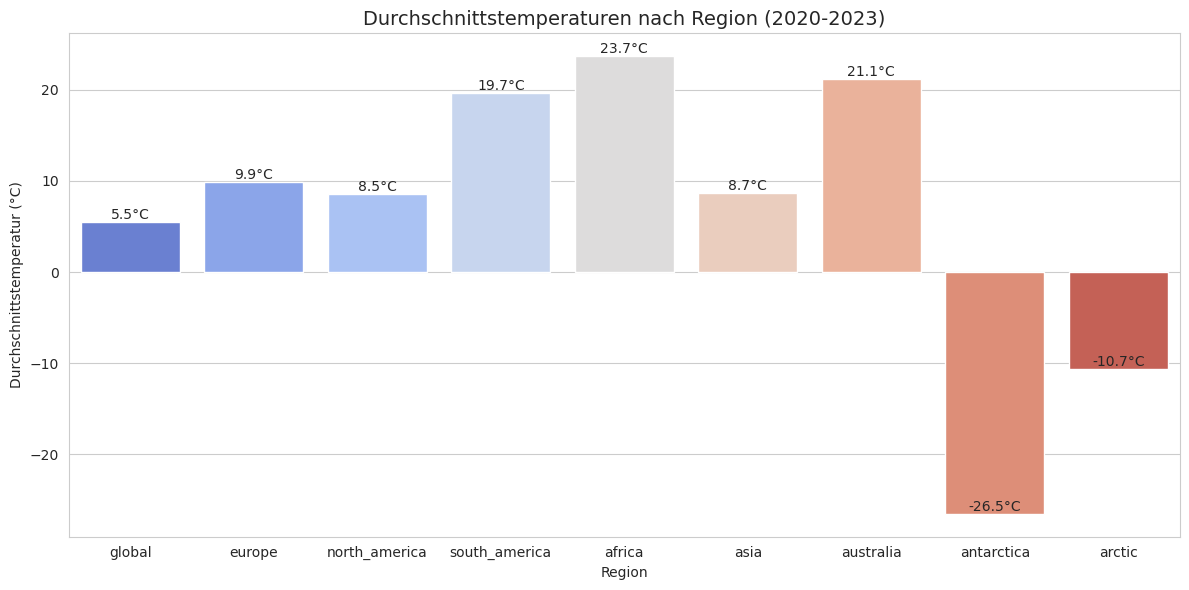

In [47]:
barplot_regional_avg_temp(
    ds,
    regions = [
    "global",
    "europe",
    "north_america",
    "south_america",
    "africa",
    "asia",
    "australia",
    "antarctica",
    "arctic"
],
    start_year=2020,
    end_year=2023
)

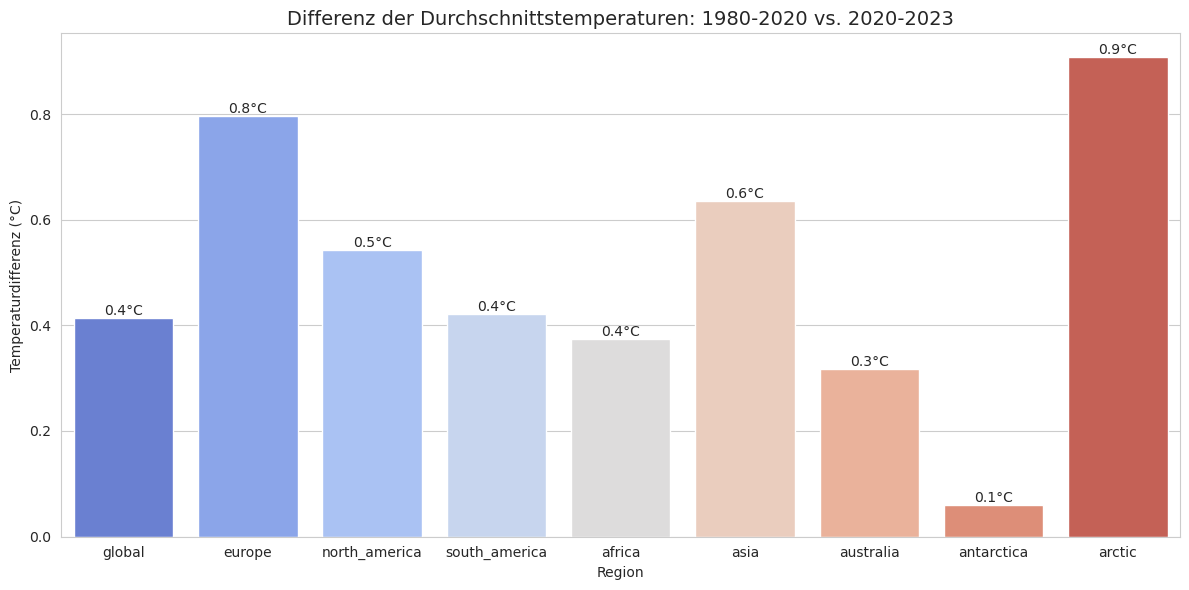

In [52]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def barplot_regional_temp_difference(ds, regions=["europe"], timeframe1="1980-2000", timeframe2="2000-2020"):
    """
    Erstellt ein Balkendiagramm, das für jede Region die Differenz der 
    Durchschnittstemperaturen zwischen zwei Zeiträumen anzeigt.
    
    Parameter:
      - ds: xarray Dataset, welches mindestens die Variable 'T2M' (Temperatur in Kelvin) enthält.
      - regions: Liste von Regionen (z.B. ["europe", "arctic"])
      - timeframe1: Erster Zeitraum als String im Format "YYYY-YYYY" (z.B. "1980-2000")
      - timeframe2: Zweiter Zeitraum als String im Format "YYYY-YYYY" (z.B. "2000-2020")
    """
    # Definitionen der Regionen (wie in deinem ursprünglichen Code)
    region_defs = {
        "europe": {'lat': (35, 70), 'lon': (-25, 45)},
        "global": {'lat': (-90, 90), 'lon': (-180, 180)},
        "north_america": {'lat': (15, 75), 'lon': (-170, -50)},
        "south_america": {'lat': (-55, 15), 'lon': (-85, -30)},
        "africa": {'lat': (-35, 37), 'lon': (-20, 55)},
        "asia": {'lat': (5, 80), 'lon': (60, 180)},
        "australia": {'lat': (-44, -10), 'lon': (112, 154)},
        "antarctica": {'lat': (-90, -60), 'lon': (-180, 180)},
        "arctic": {'lat': (66, 90), 'lon': (-180, 180)},
        "atlantic_ocean": {'lat': (-60, 60), 'lon': (-80, 20)},
        "pacific_ocean": {'lat': (-60, 60), 'lon': (-180, -80)},
        "indian_ocean": {'lat': (-50, 30), 'lon': (30, 120)},
        "southern_ocean": {'lat': (-90, -50), 'lon': (-180, 180)},
        "arctic_ocean": {'lat': (60, 90), 'lon': (-180, 180)}
    }
    
    # Prüfe, ob alle angegebenen Regionen bekannt sind
    for region in regions:
        if region not in region_defs:
            raise ValueError(f"Unbekannte Region: {region}")
    
    # Zerlege die Zeitrahmen in Start- und Endjahre
    try:
        start1, end1 = timeframe1.split("-")
        start2, end2 = timeframe2.split("-")
    except Exception as e:
        raise ValueError("Bitte gib die Zeitrahmen im Format 'YYYY-YYYY' an.") from e
    
    differences = {}
    
    # Berechne für jede Region den Mittelwert der Temperaturen für beide Zeiträume
    for region in regions:
        # Region ausschneiden
        lat_range = region_defs[region]['lat']
        lon_range = region_defs[region]['lon']
        ds_region = ds.sel(lat=slice(*lat_range), lon=slice(*lon_range))
        
        # Erster Zeitraum
        ds_tf1 = ds_region.sel(time=slice(f"{start1}-01-01", f"{end1}-12-31"))
        temp_tf1_kelvin = ds_tf1['T2M'].mean(dim=['lat', 'lon', 'time']).compute()
        temp_tf1_celsius = float(temp_tf1_kelvin - 273.15)
        
        # Zweiter Zeitraum
        ds_tf2 = ds_region.sel(time=slice(f"{start2}-01-01", f"{end2}-12-31"))
        temp_tf2_kelvin = ds_tf2['T2M'].mean(dim=['lat', 'lon', 'time']).compute()
        temp_tf2_celsius = float(temp_tf2_kelvin - 273.15)
        
        # Differenz berechnen (zweiter Zeitraum minus erster Zeitraum)
        differences[region] = temp_tf2_celsius - temp_tf1_celsius
    
    # Plot erstellen
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    ax = sns.barplot(
        x=list(differences.keys()),
        y=list(differences.values()),
        palette="coolwarm"
    )
    
    # Titel und Labels
    plt.title(f"Differenz der Durchschnittstemperaturen: {timeframe1} vs. {timeframe2}", fontsize=14)
    plt.xlabel("Region")
    plt.ylabel("Temperaturdifferenz (°C)")
    
    # Werte an den Balken anzeigen
    for bar in ax.patches:
        ax.annotate(f"{bar.get_height():.1f}°C",
                    (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


# Beispielaufruf der Funktion:
barplot_regional_temp_difference(
    ds,
    regions=[
        "global",
        "europe",
        "north_america",
        "south_america",
        "africa",
        "asia",
        "australia",
        "antarctica",
        "arctic"
    ],
    timeframe1="1980-2020",
    timeframe2="2020-2023"
)
